In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

# Redo
To debug whether the strange training curves I'm seeing with the CAFA3 data are due to my code, I'm re-running the fine-tuning done with all of the GO annotations.

In [2]:
# Load swissprot sequences, annotations, and cafa3 annotations
import os
swissprot_dir = '/projects/deepgreen/pstjohn/swissprot_go_annotation'

swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))
cafa3_accessions = np.load(os.path.join(swissprot_dir, 'cafa3_accessions.npz'), allow_pickle=True)

In [3]:
go_terms.head()

,GENE PRODUCT DB,GENE PRODUCT ID,SYMBOL,QUALIFIER,GO TERM,GO ASPECT,ECO ID,GO EVIDENCE CODE,REFERENCE,WITH/FROM,TAXON ID,ASSIGNED BY,ANNOTATION EXTENSION,DATE
0,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571|InterPro:IPR018354,8613,InterPro,None,20200613
1,UniProtKB,A2CKF6,A2CKF6,involved_in,GO:0009405,P,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571,8613,InterPro,None,20200613
2,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0964,8613,UniProt,None,20200613
3,UniProtKB,A2CKF6,A2CKF6,enables,GO:0090729,F,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0800,8613,UniProt,None,20200613
4,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0035792,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0629,8613,UniProt,None,20200613


In [4]:
go_terms['GENE PRODUCT DB'].unique()

array(['UniProtKB'], dtype=object)

In [5]:
go_terms['QUALIFIER'].unique()

array(['part_of', 'involved_in', 'enables', 'contributes_to',
       'acts_upstream_of_or_within', 'colocalizes_with',
       'NOT|involved_in', 'NOT|enables', 'acts_upstream_of',
       'is_active_in', 'acts_upstream_of_positive_effect', 'NOT|part_of',
       'NOT|acts_upstream_of_or_within',
       'acts_upstream_of_or_within_positive_effect',
       'acts_upstream_of_negative_effect',
       'acts_upstream_of_or_within_negative_effect', 'NOT|contributes_to',
       'NOT|colocalizes_with',
       'NOT|acts_upstream_of_or_within_negative_effect'], dtype=object)

In [6]:
# ignore the NOT annotations for now
not_qualifiers = [qual for qual in go_terms['QUALIFIER'].unique() if 'NOT' in qual]
print(f"removing {not_qualifiers}")
go_terms = go_terms[~go_terms['QUALIFIER'].isin(not_qualifiers)]

print(go_terms['QUALIFIER'].unique())

removing ['NOT|involved_in', 'NOT|enables', 'NOT|part_of', 'NOT|acts_upstream_of_or_within', 'NOT|contributes_to', 'NOT|colocalizes_with', 'NOT|acts_upstream_of_or_within_negative_effect']
['part_of' 'involved_in' 'enables' 'contributes_to'
 'acts_upstream_of_or_within' 'colocalizes_with' 'acts_upstream_of'
 'is_active_in' 'acts_upstream_of_positive_effect'
 'acts_upstream_of_or_within_positive_effect'
 'acts_upstream_of_negative_effect'
 'acts_upstream_of_or_within_negative_effect']


In [7]:
# Create the ontology object and backpropogate GO labels

import sys
# sys.path.append('/home/pstjohn/Research/20201119_fairseq/go_annotation')
sys.path.append('/home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/go_annotation')

from ontology import ontology
from ontology import Ontology
# ont = Ontology()
# ont.total_nodes

In [8]:
terms = go_terms['GO TERM'].unique()
print(len(terms))

28629


In [9]:
base_dir = "/home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork"
go_obo_file = f"{base_dir}/inputs/2020-12-swissprot/go-basic.obo.gz"
terms_file = f"{base_dir}/inputs/2020-12-swissprot/terms-rerun.csv.gz"
# first, read all GO terms. Then we'll limit the terms to those with at least 1 annotation
ont_obj = ontology.Ontology(obo_file=go_obo_file)
anc_terms = ont_obj.get_ancestors(terms)
print(len(anc_terms))
terms = sorted(anc_terms)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2020-12-swissprot/go-basic.obo.gz
32579


In [10]:
import gzip

In [37]:
# write these terms
# os.makedirs(dirname(terms_file), exist_ok=True)
with gzip.open(terms_file, 'wb') as out:
    out.write(('\n'.join(terms)+'\n').encode())

In [38]:
# now create another ontology object with only the part of the ontology with annotations
ont_obj = ontology.Ontology(obo_file=go_obo_file, restrict_terms_file=terms_file)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2020-12-swissprot/go-basic.obo.gz
	Reading restrict_terms_file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/2020-12-swissprot/terms-rerun.csv.gz


In [13]:
# columns: prot, term, hierarchy
prot_ids = set(go_terms['GENE PRODUCT ID'].unique())
ann_df = go_terms[['GENE PRODUCT ID', 'GO TERM', 'GO ASPECT']]
ann_df.columns = ['prot', 'term', 'hierarchy']
ann_df.head()

,prot,term,hierarchy
0,A2CKF6,GO:0005576,C
1,A2CKF6,GO:0009405,P
2,A2CKF6,GO:0005576,C
3,A2CKF6,GO:0090729,F
4,A2CKF6,GO:0035792,C


In [39]:
# now build the annotation matrix and propagate annotations upward
prots, leaf_ann_mat = ontology.build_ann_matrix(ann_df, ont_obj)
ann_mat = ontology.propagate_ann_up_dag(leaf_ann_mat, ont_obj.dag_matrix.T)

In [40]:
# this has slightly more because I included the 'part_of' edge types
len(ann_mat.data)

28726184

In [38]:
len(ann_mat.data)

26772821

<AxesSubplot:ylabel='Frequency'>

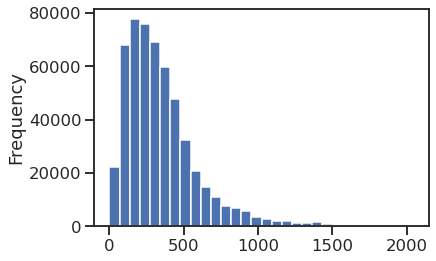

In [16]:
# Prepare for fairseq input
swissprot['str_sep_sequence'] = swissprot.sequence.str.replace("", " ").str.strip()

# Restrict swissprot to those with GO annotations
swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [17]:
uniref50_clusters = swissprot_annotated['UniRef50 ID'].unique()

# Remove cafa3 target data from swissprot data
uniref50_nocafa3 = np.array(list(set(uniref50_clusters) - set(cafa3_accessions['test'])))

# Split swissprot into training and test
print(len(uniref50_nocafa3))
np.random.seed(1)
np.random.shuffle(uniref50_nocafa3)
test, valid, train = np.split(uniref50_nocafa3, [3000, 6000])

swissprot_train = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(train)].sample(frac=1., random_state=1)
swissprot_valid = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(valid)].sample(frac=1., random_state=1)
swissprot_test = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(test)].sample(frac=1., random_state=1)

174015


In [20]:
# Create the sequence input data files
swissprot_dest_dir = '/projects/deepgreen/jlaw/swissprot_go_annotation/2020_12_fairseq_swissprot'

swissprot_train['str_sep_sequence'].to_csv(os.path.join(swissprot_dest_dir, 'input0', 'train.raw'), index=False, header=None)
swissprot_valid['str_sep_sequence'].to_csv(os.path.join(swissprot_dest_dir, 'input0', 'valid.raw'), index=False, header=None)
swissprot_test['str_sep_sequence'].to_csv(os.path.join(swissprot_dest_dir, 'input0', 'test.raw'), index=False, header=None)

In [97]:
# # Create the ontology object and backpropogate GO labels

# import sys
# sys.path.append('/home/pstjohn/Research/20201119_fairseq/go_annotation')

# from ontology import Ontology
# ont = Ontology()
# ont.total_nodes

32012

In [22]:
grouped_go_terms = go_terms.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)

In [29]:
from tqdm import tqdm

from scipy.sparse import coo_matrix, save_npz

def get_sparse_indices(accessions):
    for i, row in tqdm(enumerate(accessions)):
        for index in ont_obj.terms_to_indices(ont_obj.get_ancestors(grouped_go_terms.loc[row])):
            yield (i, index)
            
def get_csr_matrix(accessions):
    indices = np.array(list(get_sparse_indices(accessions)))
    values = np.ones(len(indices))
    cm = coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(len(accessions), ont_obj.total_nodes))
    return cm.asformat('csr')


In [41]:
train_mat = get_csr_matrix(swissprot_train.accession)
valid_mat = get_csr_matrix(swissprot_valid.accession)
test_mat = get_csr_matrix(swissprot_test.accession)

520980it [03:27, 2514.92it/s]
9826it [00:03, 2702.24it/s]
8585it [00:03, 2500.77it/s]


In [50]:
for mat in [train_mat, valid_mat, test_mat]:
    print(sum(mat.data))

27683353.0
489727.0
464492.0


In [43]:
save_npz(os.path.join(swissprot_dest_dir, 'label', 'train.npz'), train_mat)
save_npz(os.path.join(swissprot_dest_dir, 'label', 'valid.npz'), valid_mat)
save_npz(os.path.join(swissprot_dest_dir, 'label', 'test.npz'), test_mat)

In [44]:
# also create the npz files using the strategy I developed to see if it results in different values
prots, leaf_ann_mat = ontology.build_ann_matrix(ann_df, ont_obj)
ann_mat = ontology.propagate_ann_up_dag(leaf_ann_mat, ont_obj.dag_matrix.T)

In [45]:
print(len(ann_mat.data))

28726184


In [46]:
prot_index = {prot: i for i, prot in enumerate(prots)}
train_idx = [prot_index[p] for p in swissprot_train.accession]
valid_idx = [prot_index[p] for p in swissprot_valid.accession]
test_idx = [prot_index[p] for p in swissprot_test.accession]
train_mat_2 = ann_mat[train_idx,:]
valid_mat_2 = ann_mat[valid_idx,:]
test_mat_2 = ann_mat[test_idx,:]

In [49]:
for mat in [train_mat_2, valid_mat_2, test_mat_2]:
    print(sum(mat.data))

27683353
489727
464492


In [54]:
# make sure these matrices are the same
np.where(test_mat[0].A.flatten() > 0)

(array([  840,   842,  1153,  1155,  1171,  1251,  1490,  1907,  1908,
         1931,  1933,  2732,  3065,  3103,  3104,  3133,  3138,  3206,
         3233,  3234,  3246,  3252,  4107,  4108,  4110,  4111,  4232,
         4243,  4703,  5782,  5784,  5790,  6009,  6091,  6105,  6129,
         6497,  6602,  6625,  6946,  7009,  7740,  7741,  8995,  9869,
        10567, 10628, 10729, 10839, 10841, 10889, 11270, 11361, 11363,
        11775, 11825, 12794, 14435, 14866, 14891, 15582, 15598, 15599,
        15601, 15603, 15684, 15685, 16414, 16697, 18821, 18878, 18879,
        19573, 19575, 19616, 19620, 19702, 19951, 19952, 20206, 20267,
        20275, 21054, 21184, 22502, 24610, 25423, 25757, 25824, 25849,
        25998, 27014, 28052, 28243]),)

In [55]:
# make sure these matrices are the same
np.where(test_mat_2[0].A.flatten() > 0)

(array([  840,   842,  1153,  1155,  1171,  1251,  1490,  1907,  1908,
         1931,  1933,  2732,  3065,  3103,  3104,  3133,  3138,  3206,
         3233,  3234,  3246,  3252,  4107,  4108,  4110,  4111,  4232,
         4243,  4703,  5782,  5784,  5790,  6009,  6091,  6105,  6129,
         6497,  6602,  6625,  6946,  7009,  7740,  7741,  8995,  9869,
        10567, 10628, 10729, 10839, 10841, 10889, 11270, 11361, 11363,
        11775, 11825, 12794, 14435, 14866, 14891, 15582, 15598, 15599,
        15601, 15603, 15684, 15685, 16414, 16697, 18821, 18878, 18879,
        19573, 19575, 19616, 19620, 19702, 19951, 19952, 20206, 20267,
        20275, 21054, 21184, 22502, 24610, 25423, 25757, 25824, 25849,
        25998, 27014, 28052, 28243]),)

In [101]:
# with open(os.path.join(swissprot_dest_dir, 'label', 'train.label'), 'w') as f:
#     for row in tqdm(swissprot_train.accession):
#         arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
#         f.write(' '.join(np.array(arr, dtype=str)))
#         f.write('\n')        
        
# with open(os.path.join(swissprot_dest_dir, 'label', 'valid.label'), 'w') as f:
#     for row in tqdm(swissprot_valid.accession):
#         arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
#         f.write(' '.join(np.array(arr, dtype=str)))
#         f.write('\n')        
        
# with open(os.path.join(swissprot_dest_dir, 'label', 'test.label'), 'w') as f:
#     for row in tqdm(swissprot_test.accession):
#         arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
#         f.write(' '.join(np.array(arr, dtype=str)))
#         f.write('\n')        

In [ ]:
# command I used: 
#conda activate /projects/deepgreen/jlaw/envs/fairseq
!fairseq-preprocess \
    --only-source \
    --srcdict /projects/deepgreen/pstjohn/uniparc_training_data/dict.txt \
    --trainpref ./input0/train.raw \
    --validpref ./input0/valid.raw \
    --testpref ./input0/test.raw  \
    --destdir ./input0/ \
    --workers 10

In [ ]:
# copied the output to summit here: /ccs/proj/bie108/jlaw/swissprot_go_annotation

In [102]:
!fairseq-preprocess \
    --only-source \
    --srcdict /projects/deepgreen/pstjohn/uniparc_training_data/dict.txt \
    --trainpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/train.raw \
    --validpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/valid.raw \
    --testpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/test.raw \
    --destdir /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0 \
    --workers 60

2020-12-28 13:50:20 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=True, scoring='bleu', seed=1, source_lang=None, srcdict='/projects/deepgreen/pstjohn/uniparc_training_data/dict.txt', target_lang=None, task='translation', tensorboard_logdir=None, testpref='/projects/deepgreen/pstjohn/swis